Epoch [10/100], Loss: 0.0295
Epoch [20/100], Loss: 0.0098
Epoch [30/100], Loss: 0.0026
Epoch [40/100], Loss: 0.0018
Epoch [50/100], Loss: 0.0017
Epoch [60/100], Loss: 0.0013
Epoch [70/100], Loss: 0.0012
Epoch [80/100], Loss: 0.0012
Epoch [90/100], Loss: 0.0012
Epoch [100/100], Loss: 0.0011


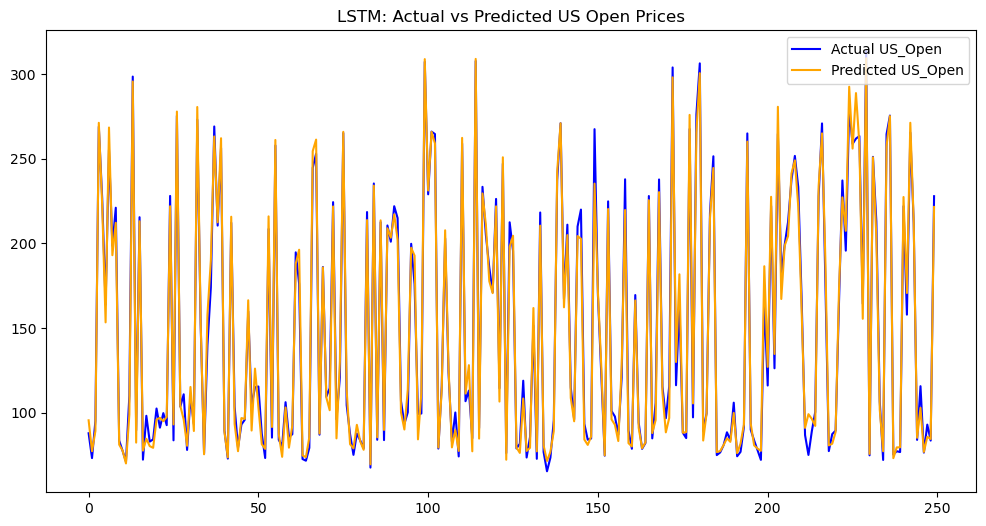

Mean Squared Error: 61.2450


In [5]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from LSTM import LSTMModel

df = pd.read_csv('stock_data.csv')

# Features and target
X = df[['HK_Close', 'US_Close', 'VIX', 'Treasury_Yield', 'RSI_US', 'US_HK_Ratio', 'US_Volume', 'HK_Volume', 'US_MA20', 'HK_MA20']]
y = df['US_Open']

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, target, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(target[i+timesteps])
    return np.array(X), np.array(y)

timesteps = 10  # Number of historical timesteps to consider
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, timesteps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Model parameters
input_size = X_train_tensor.shape[2]  # Number of features
hidden_size = 150                     # Number of LSTM units
num_layers = 2                        # Number of LSTM layers
output_size = 1                       # Single output (US_Open)
dropout = 0.2                         # Dropout to prevent overfitting

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training the model
num_epochs = 100
model.train()

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred.numpy())
    y_test_rescaled = scaler_y.inverse_transform(y_test_tensor.numpy())

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual US_Open", color='blue')
plt.plot(y_pred_rescaled, label="Predicted US_Open", color='orange')
plt.legend()
plt.title("LSTM: Actual vs Predicted US Open Prices")
plt.show()

# Calculate evaluation metrics
mse = np.mean((y_test_rescaled - y_pred_rescaled)**2)
print(f"Mean Squared Error: {mse:.4f}")


Skipped 20 sell signals due to insufficient positions.

=== Trading Performance Summary ===
Initial Cash: 100000.00
Final Portfolio Value: 129986.59
Portfolio Growth: 29.99%
Total Buys: 100, Total Sells: 91
-----------------------------------



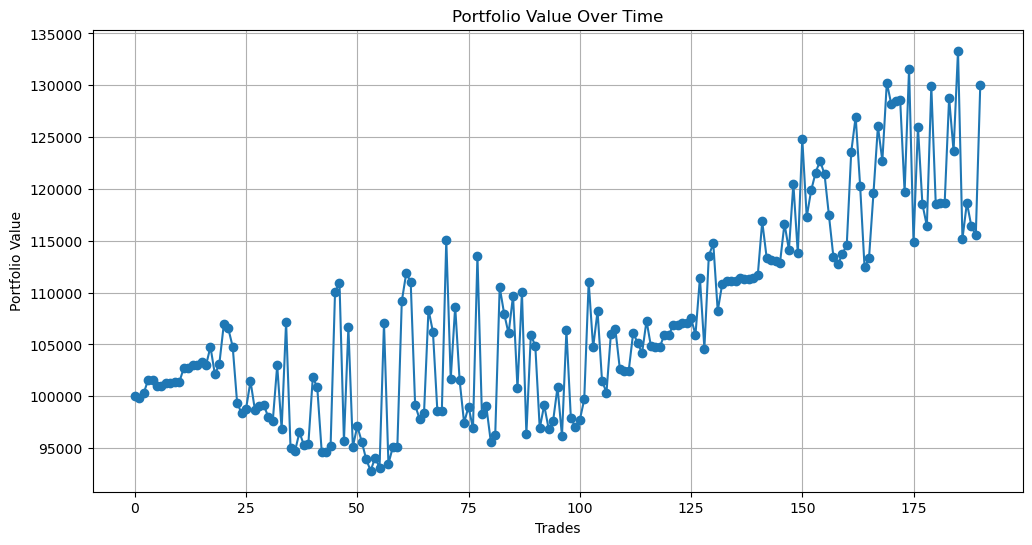

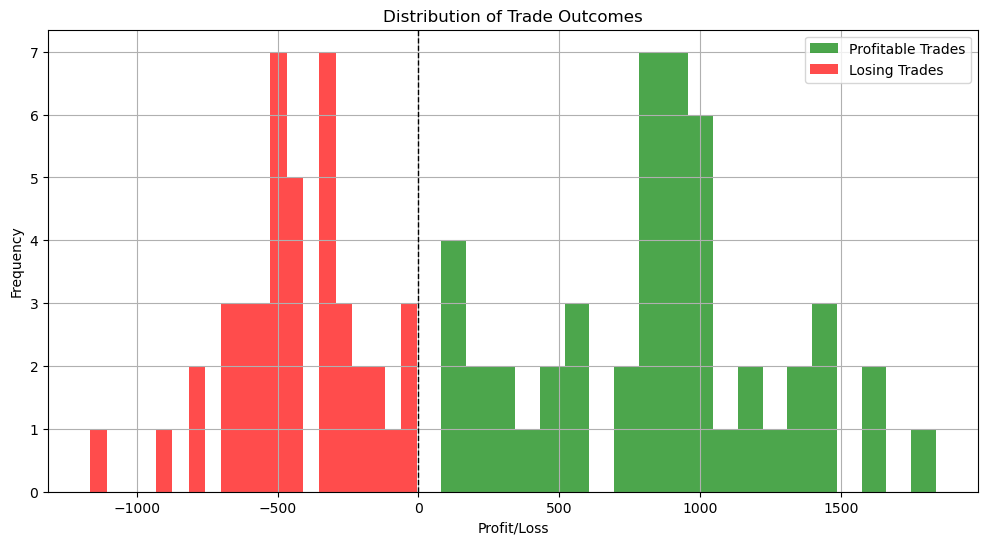


Trade Log (First 10 rows):
  Action       Price  Quantity  Profit/Loss  Portfolio Value
0    BUY   87.900002        10     0.000000     99999.121000
1    BUY   73.220001        10     0.000000     99851.588797
2   SELL   95.220001        10   145.647798    100290.636597
3   SELL  226.529999        10  1457.434674    101601.471273
4    BUY  255.339981        10     0.000000    101598.917873
5   SELL  198.649994        10  -568.886372    101030.031501
6    BUY   72.309998        10     0.000000    101029.308401
7   SELL   98.214996        10   258.067838    101287.376239
8    BUY   91.190002        10     0.000000    101286.464339
9   SELL   99.790001        10    85.002085    101371.466423


In [6]:
from TradingSimulator import TradingSimulator
import pandas as pd

# Re-perform the train-test split but keep original DataFrame indices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert X_test and y_test to DataFrames/Series with preserved indices
X_test_df = pd.DataFrame(X_test, columns=X.columns, index=X_test.index)
y_test_df = pd.Series(y_test, index=X_test.index)

# Generate trading signals based on predicted and actual values
# Signal: 1 (Buy) if prediction > actual by a threshold, -1 (Sell) if prediction < actual by a threshold, 0 (Hold)
def generate_signals(y_test, y_pred, threshold=0.01):
    signals = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    signals['signal'] = signals.apply(lambda row: 1 if (row['Predicted'] - row['Actual']) / row['Actual'] > threshold
                                      else -1 if (row['Predicted'] - row['Actual']) / row['Actual'] < -threshold
                                      else 0, axis=1)
    return signals

# Prepare the test dataset with proper alignment
# The length of y_test_rescaled might be smaller due to sequence trimming, so adjust df_test accordingly
df_test = df.loc[X_test_df.index].reset_index(drop=True)

# Make sure df_test is trimmed to the same length as y_test_rescaled if necessary
min_length = min(len(df_test), len(y_test_rescaled))

df_test = df_test.iloc[:min_length].reset_index(drop=True)
y_test_rescaled = y_test_rescaled[:min_length]
y_pred_rescaled = y_pred_rescaled[:min_length]

# Add the actual and predicted values
df_test['Actual'] = y_test_rescaled.flatten()
df_test['Predicted'] = y_pred_rescaled.flatten()

# Generate trading signals
signals = generate_signals(y_test_rescaled, y_pred_rescaled)
df_test['signal'] = signals['signal']

# Initialize and run the simulator
simulator = TradingSimulator(initial_cash=100000, transaction_fee=0.001)
simulator.run(df_test, signal_column='signal', price_column='Actual')  # Use 'Actual' or appropriate column

# Evaluate results
final_price = df_test['Actual'].iloc[-1]  # Assuming the final price is the 'Actual'
simulator.summary(final_price)
simulator.plot_portfolio_growth()
simulator.plot_trade_outcomes()

# Display the trade log
trade_log = simulator.get_trade_log()
print("\nTrade Log (First 10 rows):")
print(trade_log.head(10))
